# COMP0036: Machine Learning and Neural Computing 24/25 Coursework 

## Section 1: Introduction

The aim of this project is to use historical match data of the English Premier League to predict the full time results (FTR) of future matches occuring in February 2025. To do so, several approaches, including Logistic Regression, Naive Bayes, and Support Vector Machines (SVM) has been used.

## Section 2: Data Importing
### Section 2.1: Importing Required Libraries

In [37]:
# Importing Required Libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

### Section 2.2: Importing the Vanilla Dataset

In [38]:
# Importing the vanilla dataset
df_vanilla = pd.read_csv('epl-training.csv') 
df_vanilla['Date'] = pd.to_datetime(df_vanilla['Date'], dayfirst = True)

### Section 2.3: Importing and Combining the 2024-25 Season Data

In [39]:
# Importing the 2024-25 season data
df_latest = pd.read_csv('epl-training-2024.csv') 

# Combining the two datasets
df_matches = pd.concat([df_vanilla, df_latest])

# Ensure the match date is in datetime format
df_matches['Date'] = pd.to_datetime(df_matches['Date'], dayfirst = True)

# Sort the df_matches dataframe by ascending date order
df_matches = df_matches.sort_values(by='Date', ascending=True).reset_index(drop=True)

# Drop any rows where all the values are nan
df_matches = df_matches.dropna()

df_matches.dtypes

Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG               float64
FTAG               float64
FTR                 object
HTHG               float64
HTAG               float64
HTR                 object
Referee             object
HS                 float64
AS                 float64
HST                float64
AST                float64
HC                 float64
AC                 float64
HF                 float64
AF                 float64
HY                 float64
AY                 float64
HR                 float64
AR                 float64
dtype: object

### Section 2.3: Travel Distance and Travel Fatigue Index

In [40]:
# Travel Distance and Travel Fatigue Index

# Stadium Coordinates
stadium_coordinates = {
    'Swansea': (51.6428, -3.9347),
    'West Ham': (51.5383, -0.0166),
    'Charlton': (51.4865, 0.0368),
    'Wigan': (53.5477, -2.6542),
    'Wolves': (52.5904, -2.1306),
    'Brighton': (50.8609, -0.0801),
    'Bournemouth': (50.7352, -1.8384),
    'Blackpool': (53.8046, -3.0483),
    "Nott'm Forest": (52.9399, -1.1326),
    'Aston Villa': (52.5092, -1.8851),
    'Brentford': (51.4908, -0.2888),
    'Chelsea': (51.4816, -0.1910),
    'Coventry': (52.4481, -1.4956),
    'Sheffield United': (53.3703, -1.4708),
    'Fulham': (51.4749, -0.2216),
    'Leeds': (53.7775, -1.5721),
    'Middlesbrough': (54.5781, -1.2178),
    'Newcastle': (54.9756, -1.6218),
    'Luton': (51.8842, -0.4316),
    'Leicester': (52.6203, -1.1422),
    'Hull': (53.7465, -0.3680),
    'Huddersfield': (53.6543, -1.7684),
    'Southampton': (50.9058, -1.3911),
    'QPR': (51.5093, -0.2322),
    'Bradford': (53.8042, -1.7590),
    'Everton': (53.4387, -2.9662),
    'Blackburn': (53.7286, -2.4894),
    'Man United': (53.4631, -2.2914),
    'Stoke': (52.9884, -2.1754),
    'Reading': (51.4222, -0.9828),
    'Birmingham': (52.4756, -1.8682),
    'Liverpool': (53.4308, -2.9610),
    'Tottenham': (51.6044, -0.0664),
    'Ipswich': (52.0544, 1.1455),
    'Norwich': (52.6221, 1.3091),
    'Watford': (51.6498, -0.4016),
    'Man City': (53.4830, -2.2002),
    'Crystal Palace': (51.3983, -0.0855),
    'Derby': (52.9149, -1.4473),
    'Burnley': (53.7888, -2.2302),
    'Sunderland': (54.9146, -1.3884),
    'West Brom': (52.5090, -1.9639),
    'Arsenal': (51.5549, -0.1084),
    'Portsmouth': (50.7964, -1.0639),
    'Cardiff': (51.4729, -3.2041),
    'Bolton': (53.5805, -2.5357)
}

# Define Haversine function
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    return round(km, 3)

#Function to get both travel distance and travel fatigue index
def getTravelData(df):
    
    # Calculate travel distance
    def calculate_travel_distance(row, stadium_coordinates):
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        if home_team in stadium_coordinates and away_team in stadium_coordinates:
            home_coords = stadium_coordinates[home_team]
            away_coords = stadium_coordinates[away_team]
            return haversine(home_coords, away_coords)
        return None  # Handle missing coordinates
    
    
    # Apply the function to calculate travel distances
    df['TravelDistance'] = df.apply(
        calculate_travel_distance, axis=1, args=(stadium_coordinates,)
    )

    # Normalize Travel Distance to create a Travel Fatigue Index
    min_distance = df['TravelDistance'].min()
    max_distance = df['TravelDistance'].max()

    # Apply Travel Fatigue Index to the Dataframe
    df['TravelFatigueIndex'] = (df['TravelDistance'] - min_distance) / (
        max_distance - min_distance
    )

# Apply getTravelData to df_matches
getTravelData(df_matches)

# Display a sample of the updated dataset
display(df_matches[['HomeTeam', 'AwayTeam', 'TravelDistance', 'TravelFatigueIndex']].head(10))

,HomeTeam,AwayTeam,TravelDistance,TravelFatigueIndex
0,Charlton,Man City,333.367,0.561248
1,Chelsea,West Ham,20.392,0.032665
2,Coventry,Middlesbrough,238.785,0.401509
3,Derby,Southampton,223.421,0.375560
4,Leeds,Everton,159.522,0.267641
5,Leicester,Aston Villa,83.525,0.139290
6,Liverpool,Bradford,139.946,0.234580
7,Sunderland,Arsenal,399.739,0.673343
8,Tottenham,Ipswich,143.746,0.240997
9,Man United,Newcastle,183.836,0.308705


### Section 2.4: Team Spending Information

In [41]:
# Importing Spending Information on Signing New Players

df_spending = pd.read_csv('epl-expenditure.csv')

# Ensure Season_Start and Season_End are in datetime format
df_spending['Season_Start'] = pd.to_datetime(df_spending['Season_Start'],dayfirst = True)
df_spending['Season_End'] = pd.to_datetime(df_spending['Season_End'],dayfirst = True)

# Ensure Season_Start and Season_End are in datetime format
df_spending['Season_Start'] = pd.to_datetime(df_spending['Season_Start'],dayfirst = True)
df_spending['Season_End'] = pd.to_datetime(df_spending['Season_End'],dayfirst = True)

# Function to get the expenditure for a specific team and match date
def getSpendingData(df):
    def get_spending(team, match_date):
        spending_row = df_spending[
            (df_spending['Team'] == team) &
            (df_spending['Season_Start'] <= match_date) &
            (df_spending['Season_End'] >= match_date)
        ]
        return spending_row['Expenditure'].iloc[0] if not spending_row.empty else 0

    # Add HomeExpenditure and AwayExpenditure columns to df
    df['HomeExpenditure'] = df.apply(lambda row: get_spending(row['HomeTeam'], row['Date']), axis=1)
    df['AwayExpenditure'] = df.apply(lambda row: get_spending(row['AwayTeam'], row['Date']), axis=1)
    df['HomeExpenditure'] = df['HomeExpenditure'].fillna(0) 
    df['AwayExpenditure'] = df['AwayExpenditure'].fillna(0)
    # Replace any NaN values with 0 as NaN values correspond to when teams have not signed any new players in a season.

# Get spending data for df_matches
getSpendingData(df_matches)

# Display a sample of the updated dataset
display(df_matches[['HomeTeam', 'AwayTeam','HomeExpenditure' ,'AwayExpenditure']].head(10))

C:\Users\chenh\AppData\Local\Temp\ipykernel_23816\2303893476.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_spending['Season_Start'] = pd.to_datetime(df_spending['Season_Start'],dayfirst = True)
C:\Users\chenh\AppData\Local\Temp\ipykernel_23816\2303893476.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_spending['Season_End'] = pd.to_datetime(df_spending['Season_End'],dayfirst = True)


,HomeTeam,AwayTeam,HomeExpenditure,AwayExpenditure
0,Charlton,Man City,20.80,20.28
1,Chelsea,West Ham,52.39,18.65
2,Coventry,Middlesbrough,0.00,0.00
3,Derby,Southampton,13.33,0.00
4,Leeds,Everton,53.15,34.48
5,Leicester,Aston Villa,11.70,21.12
6,Liverpool,Bradford,34.00,0.00
7,Sunderland,Arsenal,16.87,56.30
8,Tottenham,Ipswich,25.74,9.90
9,Man United,Newcastle,0.00,25.91


### Section 2.5: Manager Information

In [42]:
# Importing Manager Information

df_managers = pd.read_csv('epl-managers.csv')

# Ensure Season_Start and Season_End are in datetime format
df_managers['Season_Start'] = pd.to_datetime(df_managers['Season_Start'],dayfirst = True)
df_managers['Season_End'] = pd.to_datetime(df_managers['Season_End'],dayfirst = True)

# Ensure Season_Start and Season_End are in datetime format
df_managers['Season_Start'] = pd.to_datetime(df_managers['Season_Start'],dayfirst = True)
df_managers['Season_End'] = pd.to_datetime(df_managers['Season_End'],dayfirst = True)

# Function to get the manager for a specific team and match date
def getManagerData(df):
    def get_manager(team, match_date):
        manager_row = df_managers[
            (df_managers['Club'] == team) &
            (df_managers['Season_Start'] <= match_date) &
            (df_managers['Season_End'] >= match_date)
        ]
        return manager_row['Manager'].iloc[0] if not manager_row.empty else None

    # Add HomeManager and AwayManager columns to df
    df['HomeManager'] = df.apply(lambda row: get_manager(row['HomeTeam'], row['Date']), axis=1)
    df['AwayManager'] = df.apply(lambda row: get_manager(row['AwayTeam'], row['Date']), axis=1)

    
# Getting the Manager Data for df_matches
getManagerData(df_matches)

# Display a sample of the updated dataset
display(df_matches[['HomeTeam', 'AwayTeam','HomeManager','AwayManager']])

C:\Users\chenh\AppData\Local\Temp\ipykernel_23816\2766057701.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_managers['Season_Start'] = pd.to_datetime(df_managers['Season_Start'],dayfirst = True)
C:\Users\chenh\AppData\Local\Temp\ipykernel_23816\2766057701.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_managers['Season_End'] = pd.to_datetime(df_managers['Season_End'],dayfirst = True)


,HomeTeam,AwayTeam,HomeManager,AwayManager
0,Charlton,Man City,Alan Curbishley,Joe Royle
1,Chelsea,West Ham,Claudio Ranieri,Glenn Roeder
2,Coventry,Middlesbrough,Gordon Strachan,Terry Venables
3,Derby,Southampton,Jim Smith,Stuart Gray
4,Leeds,Everton,David O'Leary,Walter Smith
...,...,...,...,...
9325,Brighton,Man City,Fabian Hürzeler,Pep Guardiola
9326,Nott'm Forest,Newcastle,Nuno Herlander Simões Espírito Santo,Eddie Howe
9327,Tottenham,Ipswich,Ange Postecoglou,Kieran McKenna
9328,Man United,Leicester,Ruben Filipe Marques Diogo Amorim,Steve Cooper


## Section 3: Data Transformation and Exploration
 
### Section 3.1: Data Exploration

In [43]:
# Checking what columns are present in the dataframe currently
df_matches.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF',
       'HY', 'AY', 'HR', 'AR', 'TravelDistance', 'TravelFatigueIndex',
       'HomeExpenditure', 'AwayExpenditure', 'HomeManager', 'AwayManager'],
      dtype='object')

In [44]:
# Checking the distribution of FTR Values
print(df_matches['FTR'].value_counts()) # Raw values
print(df_matches['FTR'].value_counts(normalize=True)*100) # Percentage of the results being H, A, or D

FTR
H    4287
A    2738
D    2305
Name: count, dtype: int64
FTR
H    45.948553
A    29.346195
D    24.705252
Name: proportion, dtype: float64


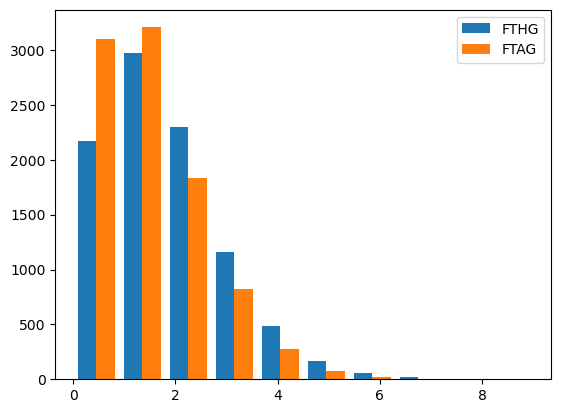

In [45]:
plt.hist(df_matches[['FTHG','FTAG']])
plt.legend(['FTHG', 'FTAG'])

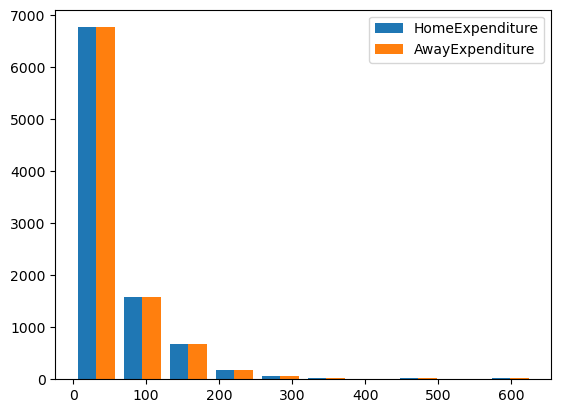

In [46]:
plt.hist(df_matches[['HomeExpenditure','AwayExpenditure']])
plt.legend(['HomeExpenditure','AwayExpenditure'])

### Section 3.2: Data Transformation

#### Section 3.2.1: Home/Away Rolling Average Statistics

In [47]:
# Calculating Rolling Average Statistics
# Function to Calculate Rolling Average Statistics for the Past k Matches. Each row's kAvg does not include the current results.
def generate_kAvg(df, k_window, attribute, HomeTeam=True):
    if HomeTeam:
        group_by_team = "HomeTeam"
    elif not HomeTeam:
        group_by_team = "AwayTeam"
    
    kattribute = "k" + attribute
    df[kattribute] = (
    df.groupby(group_by_team)[attribute]     # Group by HomeTeam or AwayTeam
    .transform(lambda x: x.shift(1).rolling(window=k_window, min_periods=1).mean())  # Shift by 1 to exclude the current match, and create a rolling window of up to k past matches
    )
    df[kattribute] = df[kattribute].fillna(0) # Filling nan values with 0

Home_kAvg_features = ['FTHG','HTHG','HS','HC','HF','HY','HR']
Away_kAvg_features = ['FTAG','HTAG','AS','AC','AF','AY','AR']


# Using Chelsea and k_window = 2 as an Example to Check Whether the Data Makes Sense
df_chelsea = df_matches[df_matches['HomeTeam'] == 'Chelsea'].copy()

for feature in Home_kAvg_features:
    generate_kAvg(df_chelsea, 2, feature, True)
for feature in Away_kAvg_features:
    generate_kAvg(df_chelsea, 2, feature, False)
display(df_chelsea[['Date', 'HomeTeam', 'AwayTeam', 'FTHG','kFTHG']])




,Date,HomeTeam,AwayTeam,FTHG,kFTHG
1,2000-08-19,Chelsea,West Ham,4.0,0.0
37,2000-09-06,Chelsea,Arsenal,2.0,4.0
56,2000-09-17,Chelsea,Leicester,0.0,3.0
77,2000-10-01,Chelsea,Liverpool,3.0,1.0
93,2000-10-21,Chelsea,Coventry,6.0,1.5
...,...,...,...,...,...
9247,2024-09-01,Chelsea,Crystal Palace,1.0,1.0
9273,2024-09-28,Chelsea,Brighton,4.0,0.5
9288,2024-10-06,Chelsea,Nott'm Forest,1.0,2.5
9306,2024-10-27,Chelsea,Newcastle,2.0,2.5


In [48]:
# Applying this with k = 38 to all the dataset

k = 38 # Number of matches to look backwards to.

def getkAvgFeatures(df):
    for feature in Home_kAvg_features:
        generate_kAvg(df, k, feature, True)
    for feature in Away_kAvg_features:
        generate_kAvg(df, k, feature, False)

getkAvgFeatures(df_matches)

#### Section 3.2.2: Home/Away All Time Win Rates Section

In [49]:
def generate_WinRates(df):
    # Create a new column to store home wins and away wins
    df['HomeWin'] = (df['FTR'] == 'H').astype(int)
    df['AwayWin'] = (df['FTR'] == 'A').astype(int)
    
    sides = ['Home', 'Away']
    
    for side in sides:
        # Home/Away Win Count
        df[f'{side}WinCount'] = (
        df.groupby(f'{side}Team')[f'{side}Win']     # Group by HomeTeam or AwayTeam
        .transform(lambda x: x.shift(1).expanding(min_periods = 1).sum())  
            # Shift by 1 to exclude the current match, and create an expanding window
        )
        df[f'{side}WinCount'] = df[f'{side}WinCount'].fillna(0) # Fill NaN values created due to the window with 0

        # Home/Away Games Played
        df[f'{side}GamesPlayed'] = (
        df.groupby(f'{side}Team')[f'{side}Team']
            .transform(lambda x: x.shift(1).expanding(min_periods = 1).count())
        )

        # Home/Away Win Rate
        df[f'{side}WinRate'] = df[f'{side}WinCount']/df[f'{side}GamesPlayed']
        df[f'{side}WinRate'] = df[f'{side}WinRate'].fillna(0) # Replace NaN values caused by zero division
    

# Applying the generate_WinRates function to df_matches
generate_WinRates(df_matches)
    
# Using Liverpool (HomeTeam) as an Example to Examine the Win Rate Calculation
df_liverpool = df_matches[df_matches['HomeTeam'] == 'Liverpool']
display(df_liverpool[['Date', 'HomeTeam','AwayTeam', 'FTR', 'HomeWin', 'HomeWinCount', 'HomeGamesPlayed', 'HomeWinRate']])

    
    
    

,Date,HomeTeam,AwayTeam,FTR,HomeWin,HomeWinCount,HomeGamesPlayed,HomeWinRate
6,2000-08-19,Liverpool,Bradford,H,1,0.0,0.0,0.000000
34,2000-09-06,Liverpool,Aston Villa,H,1,1.0,1.0,1.000000
43,2000-09-09,Liverpool,Man City,H,1,2.0,2.0,1.000000
67,2000-09-23,Liverpool,Sunderland,D,0,3.0,3.0,1.000000
95,2000-10-21,Liverpool,Leicester,H,1,3.0,4.0,0.750000
...,...,...,...,...,...,...,...,...
9250,2024-09-14,Liverpool,Nott'm Forest,A,0,301.0,462.0,0.651515
9263,2024-09-21,Liverpool,Bournemouth,H,1,301.0,463.0,0.650108
9298,2024-10-20,Liverpool,Chelsea,H,1,302.0,464.0,0.650862
9316,2024-11-02,Liverpool,Brighton,H,1,303.0,465.0,0.651613


#### Section 3.2.3: Home/Away Pairwise Statistics

In [50]:
def generate_nAvg_pairwise(df, n_window, attribute):
    n_pairwise_attribute = f"n{attribute}_Pairwise"
    
    df[n_pairwise_attribute] = (
        df.groupby(['HomeTeam','AwayTeam'])[attribute] # Groupby Home and Away Teams
        .transform(lambda x: x.shift(1).rolling(window=n_window, min_periods=1).mean())
        # Shift by 1 to exclude the current match, and create a rolling window of up to k past matches
    )
    df[n_pairwise_attribute] = df[n_pairwise_attribute].fillna(0)

    
# List of attributes to calculate team pair specific rolling averages for
attributes = ['FTHG','HTHG','HS','HC','HF','HY','HR',
              'FTAG','HTAG','AS','AC','AF','AY','AR']

for attribute in attributes:
    generate_nAvg_pairwise(df_matches, 2, attribute)

# Use Arsenal vs Manchester United using n= 2 as an example to verify results
df_ArsenalManUtd = df_matches[(df_matches['HomeTeam'] == 'Arsenal') & (df_matches['AwayTeam'] == 'Man United')].copy()

for attribute in attributes:
    generate_nAvg_pairwise(df_ArsenalManUtd, 2, attribute)

display(df_ArsenalManUtd[['Date','HomeTeam','AwayTeam','FTHG','nFTHG_Pairwise','FTAG','nFTAG_Pairwise']].head(10))

,Date,HomeTeam,AwayTeam,FTHG,nFTHG_Pairwise,FTAG,nFTAG_Pairwise
76,2000-10-01,Arsenal,Man United,1.0,0.0,0.0,0.0
509,2001-11-25,Arsenal,Man United,3.0,1.0,1.0,0.0
1089,2003-04-16,Arsenal,Man United,2.0,2.0,2.0,0.5
1437,2004-03-28,Arsenal,Man United,1.0,2.5,1.0,1.5
1760,2005-02-01,Arsenal,Man United,2.0,1.5,4.0,1.5
2102,2006-01-03,Arsenal,Man United,0.0,1.5,0.0,2.5
2516,2007-01-21,Arsenal,Man United,2.0,1.0,1.0,2.0
2772,2007-11-03,Arsenal,Man United,2.0,1.0,2.0,0.5
3153,2008-11-08,Arsenal,Man United,2.0,2.0,1.0,1.5
3648,2010-01-31,Arsenal,Man United,1.0,2.0,3.0,1.5


In [51]:
# Generate the Statistic for the actual dataframe
n = 5
def getnAvg_pairwiseFeatures(df):
    for attribute in attributes:
        generate_nAvg_pairwise(df_matches, n, attribute)
        
getnAvg_pairwiseFeatures(df_matches)

In [52]:
# Showing what columns are present in the current dataframe
df_matches.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF',
       'HY', 'AY', 'HR', 'AR', 'TravelDistance', 'TravelFatigueIndex',
       'HomeExpenditure', 'AwayExpenditure', 'HomeManager', 'AwayManager',
       'kFTHG', 'kHTHG', 'kHS', 'kHC', 'kHF', 'kHY', 'kHR', 'kFTAG', 'kHTAG',
       'kAS', 'kAC', 'kAF', 'kAY', 'kAR', 'HomeWin', 'AwayWin', 'HomeWinCount',
       'HomeGamesPlayed', 'HomeWinRate', 'AwayWinCount', 'AwayGamesPlayed',
       'AwayWinRate', 'nFTHG_Pairwise', 'nHTHG_Pairwise', 'nHS_Pairwise',
       'nHC_Pairwise', 'nHF_Pairwise', 'nHY_Pairwise', 'nHR_Pairwise',
       'nFTAG_Pairwise', 'nHTAG_Pairwise', 'nAS_Pairwise', 'nAC_Pairwise',
       'nAF_Pairwise', 'nAY_Pairwise', 'nAR_Pairwise'],
      dtype='object')


### Section 3.3: Building a Pipeline to Encode and Scale Numerical Data

In [53]:
# Defining the input features
# Numerical Input Features
num_column = ['HomeExpenditure', 'AwayExpenditure', 
                'TravelDistance', 'TravelFatigueIndex',
                'kFTHG', 'kHTHG','kHS', 'kHC', 'kHF', 'kHY', 'kHR', 
                'kFTAG', 'kHTAG', 'kAS', 'kAC', 'kAF', 'kAY', 'kAR', 
                'HomeWinRate', 'AwayWinRate', 
                'nFTHG_Pairwise', 'nHTHG_Pairwise', 'nHS_Pairwise', 'nHC_Pairwise',
                'nHF_Pairwise', 'nHY_Pairwise', 'nHR_Pairwise', 
                'nFTAG_Pairwise','nHTAG_Pairwise', 'nAS_Pairwise', 'nAC_Pairwise', 
                'nAF_Pairwise','nAY_Pairwise', 'nAR_Pairwise']
# Categorical Input Features
cat_column = ['HomeTeam', 'AwayTeam', 'HomeManager', 'AwayManager']

# Combined Input Features
input_features = cat_column + num_column
X = df_matches[input_features] # The dataframe containing the combined features
display(X)
# Display the amount of features in X
num_features = X.shape[1]
print(f'The number of features in X: {num_features}')


,HomeTeam,AwayTeam,HomeManager,AwayManager,HomeExpenditure,AwayExpenditure,TravelDistance,TravelFatigueIndex,kFTHG,kHTHG,...,nHF_Pairwise,nHY_Pairwise,nHR_Pairwise,nFTAG_Pairwise,nHTAG_Pairwise,nAS_Pairwise,nAC_Pairwise,nAF_Pairwise,nAY_Pairwise,nAR_Pairwise
0,Charlton,Man City,Alan Curbishley,Joe Royle,20.80,20.28,333.367,0.561248,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Chelsea,West Ham,Claudio Ranieri,Glenn Roeder,52.39,18.65,20.392,0.032665,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Coventry,Middlesbrough,Gordon Strachan,Terry Venables,0.00,0.00,238.785,0.401509,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Derby,Southampton,Jim Smith,Stuart Gray,13.33,0.00,223.421,0.375560,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Leeds,Everton,David O'Leary,Walter Smith,53.15,34.48,159.522,0.267641,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9325,Brighton,Man City,Fabian Hürzeler,Pep Guardiola,0.00,25.00,374.889,0.631374,1.921053,0.868421,...,10.0,2.0,0.0,3.2,2.0,16.8,4.0,7.0,1.4,0.2
9326,Nott'm Forest,Newcastle,Nuno Herlander Simões Espírito Santo,Eddie Howe,105.50,68.20,232.740,0.391299,1.447368,0.631579,...,10.5,3.0,0.0,2.5,1.5,11.0,6.5,6.5,1.5,0.0
9327,Tottenham,Ipswich,Ange Postecoglou,Kieran McKenna,148.85,126.49,143.746,0.240997,2.026316,0.684211,...,18.0,0.5,0.5,1.5,1.0,13.5,4.5,14.5,1.0,0.0
9328,Man United,Leicester,Ruben Filipe Marques Diogo Amorim,Steve Cooper,214.50,86.05,158.441,0.265816,1.500000,0.473684,...,11.2,1.0,0.0,0.8,0.2,12.8,5.8,9.8,1.4,0.0


The number of features in X: 38


In [54]:
# Output Feature
ouput_feature = 'FTR'
Y = df_matches['FTR']
display(Y)

0       H
1       H
2       A
3       D
4       H
       ..
9325    H
9326    A
9327    A
9328    H
9329    D
Name: FTR, Length: 9330, dtype: object

The following code block is adapted from https://www.kaggle.com/code/caesarmario/listen-to-your-heart-a-disease-prediction. The function below is used to create the pipeline for OneHotEncoding categorical columns, and scaling numerical columns using a Standard Scaler.


In [55]:
# Numerical Input Features
num_pipeline = Pipeline([
    ('scaling', StandardScaler())
])

# Categorical Input Features
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False)) 
    # Onehot Encoder and Ignore Future Unknown Variables
])

# Combining the Numerical and Categorical Input Pipelines Together
preprocesser = ColumnTransformer([
    ('categorial', cat_pipeline, cat_column),
    ('numerical', num_pipeline, num_column)],
    remainder = 'drop')

# Adding the Preprocessor to a Pipeline
preprocess_pipeline = Pipeline([
    ('preprocesser', preprocesser)
])

# Applying the data transformations to the dataframe
X = preprocess_pipeline.fit_transform(X)

print(X)

[[ 0.          0.          0.         ... -1.90765724 -1.4606583
  -0.43844414]
 [ 0.          0.          0.         ... -1.90765724 -1.4606583
  -0.43844414]
 [ 0.          0.          0.         ... -1.90765724 -1.4606583
  -0.43844414]
 ...
 [ 0.          0.          0.         ...  0.85444274 -0.45869338
  -0.43844414]
 [ 0.          0.          0.         ... -0.04085864 -0.05790742
  -0.43844414]
 [ 0.          0.          0.         ... -0.15515243  0.54327154
  -0.43844414]]


In [56]:
#Label Encoding the Output Feature
le = LabelEncoder()
Y = le.fit_transform(Y)

display(Y)

array([2, 2, 0, ..., 0, 2, 1])

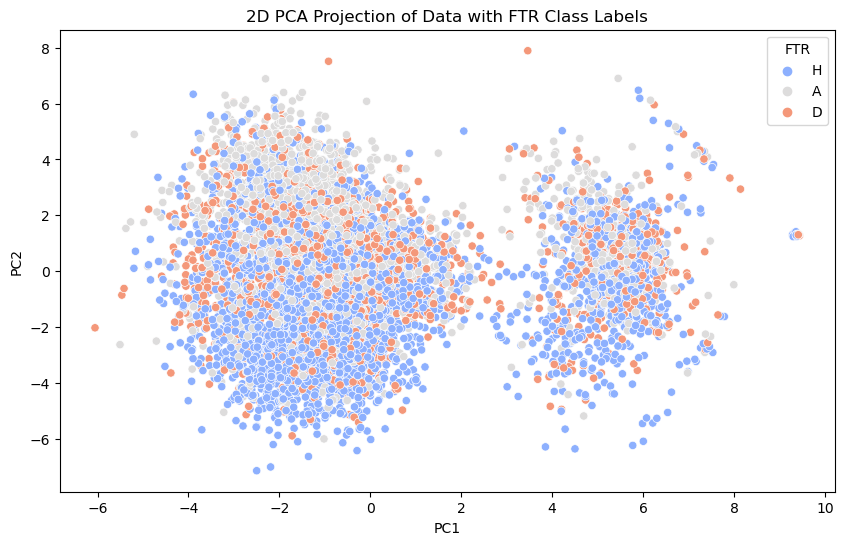

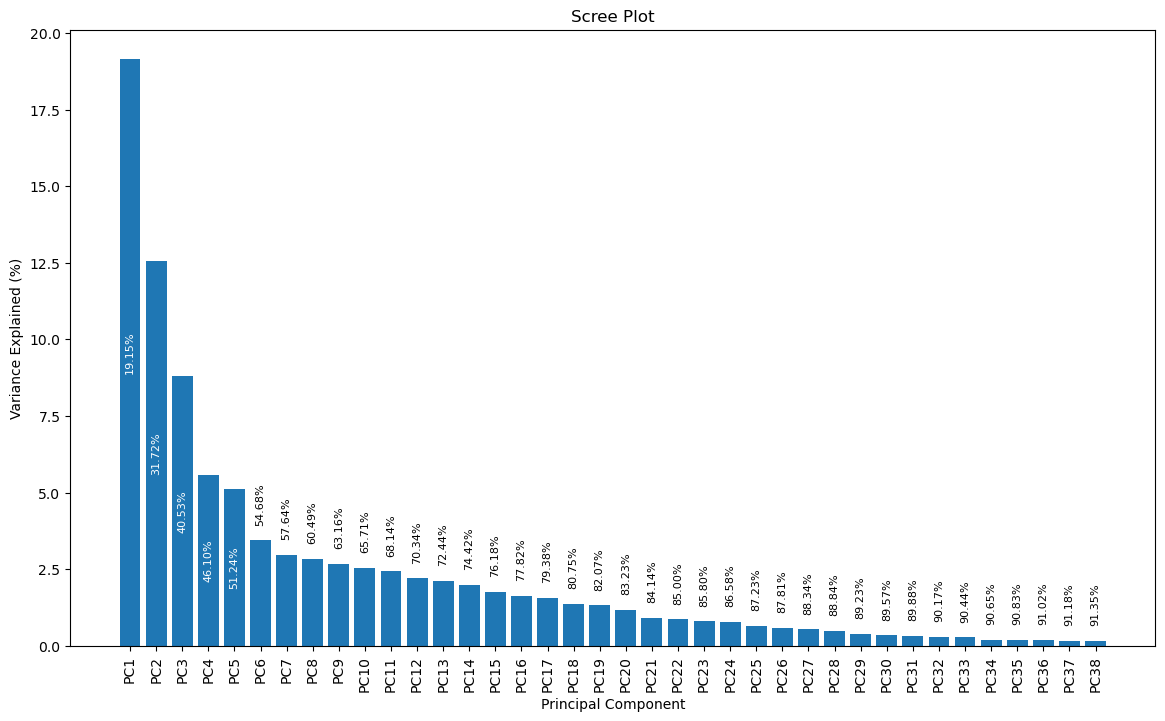

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Assuming X and Y are already defined and preprocessed
# le should be a LabelEncoder fitted on Y

def plotPCADistribution(X, Y):
    # Apply PCA
    pca = PCA(n_components=2)  # Reduce to 2D for visualization
    X_pca = pca.fit_transform(X)

    # Create a DataFrame with the first two PCA components and FTR_Encoded
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['FTR'] = le.inverse_transform(Y)

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='FTR', palette='coolwarm', alpha=1)
    plt.title('2D PCA Projection of Data with FTR Class Labels')
    plt.show()

def plotScreePlot(X):
    # Apply PCA
    pca = PCA(n_components=38)
    pca.fit(X)

    # Variance explained by each component
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Create scree plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(1, 39), explained_variance * 100, tick_label=[f'PC{i}' for i in range(1, 39)])
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.title('Scree Plot')

    # Add cumulative variance text
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 5:  # Adjust this threshold as needed
            plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, f'{cumulative_variance[i] * 100:.2f}%', 
                     ha='center', va='center', rotation='vertical', color='white', fontsize=8)
        else:
            plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.5, f'{cumulative_variance[i] * 100:.2f}%', 
                     ha='center', va='bottom', rotation='vertical', fontsize=8)

    # Rotate x-axis labels
    plt.xticks(rotation='vertical')

    plt.show()

# Assuming X and Y are already defined and preprocessed
plotPCADistribution(X, Y)
plotScreePlot(X)





In [58]:
# Split the Data into Training and Testing Sets Manually
train_size = int(X.shape[0] * 0.66)  # Use 66% for training, 33% for testing
# Split data into train and test
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

## Section 5: Model Training and Validation

### Section 5.1: Function for Model Training and Validation

The following code block is adapated from: https://www.kaggle.com/code/caesarmario/listen-to-your-heart-a-disease-prediction. The following function uses a TimeSeriesSplit of the data to ensure no data leakage, and performs hyperparameter tuning for the models using a GridSearchCV Cross Validation Method.

In [59]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

def fit_ml_models(algo, algo_param, algo_name):
    # --- Algorithm Pipeline with PCA ---
    pipeline = Pipeline([
        ('scaler', StandardScaler()),   # Standardize data before PCA
        ('pca', PCA()),                 # PCA for dimensionality reduction
        ('algo', algo)                  # Model (Logistic Regression, etc.)
    ])
    
    # --- Update Param Grid to Include PCA n_components ---
    pca_n_components = [32]   # Example PCA components to tune
    algo_param = {
        **algo_param,               # Include the existing algorithm hyperparameters
        'pca__n_components': pca_n_components  # Add PCA hyperparameter
    }
    
    tscv = TimeSeriesSplit()  # TimeSeriesSplit for CV to preserve order and prevent data leakage
    
    # --- Apply Grid Search ---
    model = GridSearchCV(pipeline, param_grid=algo_param, cv=tscv, scoring='f1_weighted', n_jobs=-1, verbose=1)
    
    # --- Fitting Model ---
    print(f".:. Fitting {algo_name} with PCA .:.")
    fit_model = model.fit(X_train, Y_train)
    
    # --- Model Best Parameters ---
    best_params = model.best_params_
    print("\n>> Best Parameters: " + f"{best_params}")
    
    # --- Best & Final Estimators ---
    best_model = model.best_estimator_
    best_estimator = model.best_estimator_.named_steps['algo']
    best_score = round(model.best_score_, 4)
    print(">> Best Score: " + "{:.3f}".format(best_score))
    
    # --- Create Predictions for Train & Test ---
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    
    # --- Train & Test Accuracy Score ---
    acc_score_train = round(accuracy_score(Y_train, Y_pred_train) * 100, 3)
    acc_score_test = round(accuracy_score(Y_test, Y_pred_test) * 100, 3)
    print("\n" + f".:. Train and Test Accuracy Score for {algo_name} with PCA .:.")
    print("\t>> Train Accuracy: " + "{:.2f}%".format(acc_score_train))
    print("\t>> Test Accuracy: " + "{:.2f}%".format(acc_score_test))
    
    # --- Classification Report ---
    print("\n" + f".:. Classification Report for {algo_name} with PCA .:.")
    print(classification_report(le.inverse_transform(Y_test), le.inverse_transform(Y_pred_test)))
    
    return best_model, acc_score_train, acc_score_test, best_score

    

### Section 5.2 Logistic Regression

In [60]:
# Hyperparameters to Optimise
l1_ratio = np.arange(0, 1, 0.2) # Ratio of l1 in an elastic net solver
C = np.logspace(-3, 3, 10) # Trade off parameter (Smaller Values -> Stronger regularisation, more risk of underfitting)


algo = LogisticRegression(solver = 'saga', multi_class = 'multinomial', penalty = 'elasticnet', max_iter = 1000)
algo_param = { 'algo__l1_ratio': l1_ratio,"algo__C": C}
algo_name = "Logistic Regression"

best_logistic_model, acc_score_train, acc_score_test, best_score  = fit_ml_models(algo, algo_param, algo_name)

.:. Fitting Logistic Regression with PCA .:.
Fitting 5 folds for each of 50 candidates, totalling 250 fits

>> Best Parameters: {'algo__C': 1000.0, 'algo__l1_ratio': 0.6000000000000001, 'pca__n_components': 32}
>> Best Score: 0.449

.:. Train and Test Accuracy Score for Logistic Regression with PCA .:.
	>> Train Accuracy: 52.56%
	>> Test Accuracy: 53.42%

.:. Classification Report for Logistic Regression with PCA .:.
              precision    recall  f1-score   support

           A       0.51      0.58      0.54      1016
           D       0.21      0.01      0.03       718
           H       0.55      0.76      0.64      1439

    accuracy                           0.53      3173
   macro avg       0.43      0.45      0.40      3173
weighted avg       0.46      0.53      0.47      3173



### Section 5.3: Gaussian Naive Bayes

In [61]:
# Hyperparameters to Optimise
var_smoothing = np.arange(0.05,0.15,0.01)

algo = GaussianNB()
algo_param = {"algo__var_smoothing": var_smoothing}
algo_name= "Gaussian Naive Bayes"
best_nb_model, acc_score_train, acc_score_test, best_score = fit_ml_models(algo, algo_param, algo_name)

.:. Fitting Gaussian Naive Bayes with PCA .:.
Fitting 5 folds for each of 10 candidates, totalling 50 fits

>> Best Parameters: {'algo__var_smoothing': 0.05, 'pca__n_components': 32}
>> Best Score: 0.452

.:. Train and Test Accuracy Score for Gaussian Naive Bayes with PCA .:.
	>> Train Accuracy: 51.88%
	>> Test Accuracy: 51.66%

.:. Classification Report for Gaussian Naive Bayes with PCA .:.
              precision    recall  f1-score   support

           A       0.49      0.60      0.54      1016
           D       0.24      0.07      0.11       718
           H       0.57      0.68      0.62      1439

    accuracy                           0.52      3173
   macro avg       0.43      0.45      0.42      3173
weighted avg       0.47      0.52      0.48      3173



### Section 5.4 Support Vector Machines (SVM)

In [62]:
# Hyperparameters to Optimise
C = np.logspace(-3,3,10) # Regularisation Parameter

algo = SVC(kernel = 'rbf', gamma = 'scale',probability=True)
algo_param = {"algo__C": C}
algo_name= "Support Vector Machines"
best_svm_model, acc_score_train, acc_score_test, best_score = fit_ml_models(algo, algo_param, algo_name)

.:. Fitting Support Vector Machines with PCA .:.
Fitting 5 folds for each of 10 candidates, totalling 50 fits

>> Best Parameters: {'algo__C': 2.154434690031882, 'pca__n_components': 32}
>> Best Score: 0.448

.:. Train and Test Accuracy Score for Support Vector Machines with PCA .:.
	>> Train Accuracy: 61.99%
	>> Test Accuracy: 51.18%

.:. Classification Report for Support Vector Machines with PCA .:.
              precision    recall  f1-score   support

           A       0.49      0.53      0.51      1016
           D       0.26      0.06      0.09       718
           H       0.54      0.72      0.62      1439

    accuracy                           0.51      3173
   macro avg       0.43      0.44      0.41      3173
weighted avg       0.46      0.51      0.47      3173



In [63]:
# Hyperparameters to Optimise
C = np.logspace(-3,3,10) # Regularisation Parameter

algo = LinearSVC(penalty='l1', dual=False)  # L1 regularization
algo_param = {"algo__C": C}
algo_name= "Linear Support Vector Machines"
best_lsvm_model, acc_score_train, acc_score_test, best_score = fit_ml_models(algo, algo_param, algo_name)

.:. Fitting Linear Support Vector Machines with PCA .:.
Fitting 5 folds for each of 10 candidates, totalling 50 fits

>> Best Parameters: {'algo__C': 10.0, 'pca__n_components': 32}
>> Best Score: 0.443

.:. Train and Test Accuracy Score for Linear Support Vector Machines with PCA .:.
	>> Train Accuracy: 52.90%
	>> Test Accuracy: 53.23%

.:. Classification Report for Linear Support Vector Machines with PCA .:.
              precision    recall  f1-score   support

           A       0.51      0.58      0.55      1016
           D       0.16      0.01      0.03       718
           H       0.55      0.76      0.64      1439

    accuracy                           0.53      3173
   macro avg       0.41      0.45      0.40      3173
weighted avg       0.45      0.53      0.47      3173



## Section 6: Results

Comparing the performance of the various models used to train the data

In [64]:
#ROC/AUC for comparison of models 

In [65]:
best_model = best_logistic_model # Input the model of the model chosen for predicting the final test set
# best_logistic_model, best_nb_model, best_lsvm_model (This will invoke the final prediction on the best_model)

print(best_model)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=32)),
                ('algo',
                 LogisticRegression(C=1000.0, l1_ratio=0.6000000000000001,
                                    max_iter=1000, multi_class='multinomial',
                                    penalty='elasticnet', solver='saga'))])


## Section 7: Final Predictions on Test Set

Predicting the Match Results for the 2024-25 Season

### Section 7.1: Importing the Test Set

In [66]:
# Importing the matches that needs to be predicted
df_test = pd.read_csv('epl-test.csv')

# Ensure the match date is in datetime format
df_test['Date'] = pd.to_datetime(df_test['Date'], dayfirst = True)

# Number of rows of the df_test dataframe
test_rows = len(df_test.index)

#Create a copy of the dataframe to export later
df_export = df_test.copy()

df_test.head()

C:\Users\chenh\AppData\Local\Temp\ipykernel_23816\3781587267.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test['Date'] = pd.to_datetime(df_test['Date'], dayfirst = True)


,Date,HomeTeam,AwayTeam
0,2025-02-01,AFC Bournemouth,Liverpool
1,2025-02-01,Arsenal,Man City
2,2025-02-01,Brentford,Spurs
3,2025-02-01,Chelsea,West Ham
4,2025-02-01,Everton,Leicester City


In [67]:
# Replacing the inconsistent team names with the team names used previously
df_test.replace(to_replace = 'AFC Bournemouth', value= 'Bournemouth', inplace = True)
df_test.replace(to_replace = 'Ipswich Town', value= 'Ipswich', inplace = True)
df_test.replace(to_replace = 'Man Utd', value= 'Man United', inplace = True)
df_test.replace(to_replace = 'Nottingham Forest', value= "Nott'm Forest", inplace = True)
df_test.replace(to_replace = 'Leicester City', value= "Leicester", inplace = True)
df_test.replace(to_replace = 'Spurs', value= "Tottenham", inplace = True)

### Section 7.2: Populating Additional Features and Perform Prediction

In [68]:
# Function to get additional data from other sources
def preparePrediction(df):
    #Get Additional Data
    getSpendingData(df)
    getManagerData(df)
    
    # Combine with the original df
    df_merged = pd.concat([df_matches,df]) # Merging the two dataframes together
    df_merged = df_merged.sort_values(by='Date', ascending=True).reset_index(drop=True) # Sort by date

    # Getting Travel Data
    getTravelData(df_merged)
    
    # Generating Additional Features
    getkAvgFeatures(df_merged)
    generate_WinRates(df_merged)
    getnAvg_pairwiseFeatures(df_merged)
    
    # Get the input features
    df_allfeatures = df_merged.tail(test_rows).fillna(0).copy()
    X = df_allfeatures[input_features]
    
    # Feedthrough into data preprocessing pipeline
    X_pred = preprocess_pipeline.transform(X) # Transformed dataframe for prediction
    
    return X_pred

In [69]:
# Predicting the outcome of future matches
X_pred = preparePrediction(df_test) # Generate the input feature matrix

print(best_model) # Print what the best model and the parameters are

FTR_pred = best_model.predict(X_pred) # Making the prediction using the best predictor
FTR_pred = le.inverse_transform(FTR_pred) # Inverse Transform of the Label Encoder Back into a Human Readable format

df_export['FTR'] = FTR_pred

# Write the Predictions to a CSV file
df_export.to_csv('epl-predictions.csv')

display(df_export)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=32)),
                ('algo',
                 LogisticRegression(C=1000.0, l1_ratio=0.6000000000000001,
                                    max_iter=1000, multi_class='multinomial',
                                    penalty='elasticnet', solver='saga'))])


,Date,HomeTeam,AwayTeam,FTR
0,2025-02-01,AFC Bournemouth,Liverpool,H
1,2025-02-01,Arsenal,Man City,H
2,2025-02-01,Brentford,Spurs,H
3,2025-02-01,Chelsea,West Ham,H
4,2025-02-01,Everton,Leicester City,H
5,2025-02-01,Ipswich Town,Southampton,A
6,2025-02-01,Man Utd,Crystal Palace,H
7,2025-02-01,Newcastle,Fulham,A
8,2025-02-01,Nottingham Forest,Brighton,H
9,2025-02-01,Wolves,Aston Villa,A
